In [1]:
### Spark Imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('KMS').getOrCreate()

In [2]:
### Spark ML Imports
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors

In [3]:
### Pyhton Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from PIL import Image
from collections import Counter
from scipy import ndimage

In [4]:
# Display parameters
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


(800, 800)


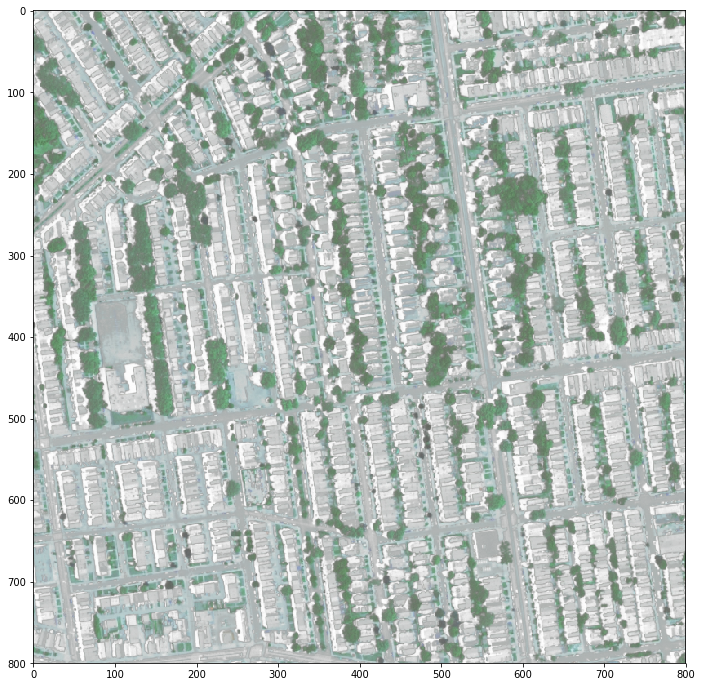

In [5]:
# Read image
fileName = "NAIP_minis/0_2400.tif"
image = Image.open(fileName)
imageW = image.size[0]
imageH = image.size[1]

# Number of clusters
K = 5

# To mask out non-vegetation region
mask_flag = 0 # 0 for more green, 1 for less green!

print (image.size)
plt.imshow(image)

In [6]:
# Initialise dataVector with attributes for each pixel
dataVector = np.ndarray(shape=(imageW * imageH, 13), dtype=float)

# Populate data vector with data from input image
for y in range(0, imageH):
    for x in range(0, imageW):
        xy = (x, y)
        rgb = image.getpixel(xy)
        
        dataVector[x + y * imageW, 0] = rgb[0]
        dataVector[x + y * imageW, 1] = rgb[1]
        dataVector[x + y * imageW, 2] = rgb[2]
        dataVector[x + y * imageW, 3] = rgb[3]
        dataVector[x + y * imageW, 4] = 0
        dataVector[x + y * imageW, 5] = 0
        dataVector[x + y * imageW, 6] = 0
        dataVector[x + y * imageW, 7] = 0
        dataVector[x + y * imageW, 8] = 0
        dataVector[x + y * imageW, 9] = 0
        dataVector[x + y * imageW, 10] = 0
        dataVector[x + y * imageW, 11] = x
        dataVector[x + y * imageW, 12] = y

In [7]:
# NDVI calculation
num = (dataVector[:, 3] - dataVector[:, 0])
den = (dataVector[:, 3] + dataVector[:, 0])
dataVector[:, 4] = num / den

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [8]:
# EVI calculation
G = 2.5
L = 1
C1 = 6
C2 = 7.5
num = (dataVector[:, 3] - dataVector[:, 0])
den = (dataVector[:, 3] + (C1 * dataVector[:, 0]) - (C2 * dataVector[:, 2]) + L)

idx = np.where(den == 0)
num[idx] = 0
den[idx] = 1

dataVector[:, 5] = num / den

In [9]:
# GIT calculation
t1 = (dataVector[:, 1] - dataVector[:, 2])
t2 = (dataVector[:, 3] - dataVector[:, 2])

idx = np.where(t1 == 0)
t2[idx] = 0
t1[idx] = 1

dataVector[:, 6] = (t2 / t1) - 1

In [10]:
# ARVI calculation
num = (dataVector[:, 3] - (2 * dataVector[:, 0] - dataVector[:, 2]))
den = (dataVector[:, 3] + (2 * dataVector[:, 0] + dataVector[:, 2]))

dataVector[:, 7] = (num/den)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [11]:
# VARI calculation
num = (dataVector[:, 1] - dataVector[:, 0])
den = (dataVector[:, 0] + dataVector[:, 1] + dataVector[:, 2])

dataVector[:, 8] = (num/den)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [12]:
# SAVI calculation
L = 0.5
num = (dataVector[:, 3] - dataVector[:, 0])
den = (dataVector[:, 3] + dataVector[:, 0] + L)

dataVector[:, 9] = (num/den) * (1 + L)

In [13]:
# CI calculation
num = (dataVector[:, 0] - dataVector[:, 2])
den = (dataVector[:, 0] + dataVector[:, 2])

dataVector[:, 10] = (num/den)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [14]:
# Mask non-vegetation pixels
maskName = fileName[11:-4] + "_mask.npy"
maskPath = "NAIP_masksnpy/" + str(maskName)
mask = np.load(maskPath)
idx_mask = np.array(np.where(mask==mask_flag)[0])
dataVector_mask = dataVector[idx_mask]
print (idx_mask.shape)
print (dataVector.shape)
print (dataVector_mask.shape)

(305925,)
(640000, 13)
(305925, 13)


In [15]:
# Convert Numpy array to Pandas Dataframe
temp_df = pd.DataFrame(dataVector_mask[:, 0:11], columns=list('RGBINEZAVSC'))
temp_df = temp_df.fillna(0)
temp_df.head()

,R,G,B,I,N,E,Z,A,V,S,C
0,103.0,109.0,107.0,135.0,0.134454,-0.659794,13.0,0.080357,0.018809,0.201258,-0.019048
1,192.0,201.0,200.0,202.0,0.025381,-0.068966,1.0,0.022901,0.015177,0.038023,-0.020408
2,212.0,216.0,217.0,219.0,0.016241,-0.051661,-3.0,0.013953,0.006202,0.024334,-0.011655
3,202.0,206.0,207.0,209.0,0.017032,-0.053640,-3.0,0.014634,0.006504,0.025516,-0.012225
4,166.0,170.0,169.0,173.0,0.020649,-0.071795,3.0,0.014837,0.007921,0.030928,-0.008955


In [16]:
# Convert Pandas Dataframe to Spark Dataframe
df = spark.createDataFrame(temp_df)
df.show(5)

+-----+-----+-----+-----+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|    R|    G|    B|    I|                   N|                   E|   Z|                   A|                   V|                   S|                   C|
+-----+-----+-----+-----+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|103.0|109.0|107.0|135.0| 0.13445378151260504| -0.6597938144329897|13.0| 0.08035714285714286|0.018808777429467086| 0.20125786163522014|-0.01904761904761905|
|192.0|201.0|200.0|202.0|0.025380710659898477|-0.06896551724137931| 1.0|0.022900763358778626| 0.01517706576728499| 0.03802281368821293|-0.02040816326530612|
|212.0|216.0|217.0|219.0|0.016241299303944315|-0.05166051660516605|-3.0|0.013953488372093023|0.006201550387596899| 0.02433371958285052|-0.01165501165501...|
|202.0|206.0|207.0|209.0|  0.0170316301703163|-0.053639846

In [17]:
# Generate feature vector from Spark Dataframe
vecAssembler = VectorAssembler(inputCols=["R", "G", "B", "I", "N", "E", "Z", "A", "V", "S", "C"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show(5)

+-----+-----+-----+-----+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    R|    G|    B|    I|                   N|                   E|   Z|                   A|                   V|                   S|                   C|            features|
+-----+-----+-----+-----+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|103.0|109.0|107.0|135.0| 0.13445378151260504| -0.6597938144329897|13.0| 0.08035714285714286|0.018808777429467086| 0.20125786163522014|-0.01904761904761905|[103.0,109.0,107....|
|192.0|201.0|200.0|202.0|0.025380710659898477|-0.06896551724137931| 1.0|0.022900763358778626| 0.01517706576728499| 0.03802281368821293|-0.02040816326530612|[192.0,201.0,200....|
|212.0|216.0|217.0|219.0|0.016241299303944315|-0.05166051660516605|-3.0|0.013953488372093023|0.006201550387596

In [18]:
# Clustering into k clusters
kmeans = KMeans(k=K, seed=1)
model = kmeans.fit(new_df.select('features'))

In [19]:
# Display cluster ID for each pixel
transformed = model.transform(new_df)
transformed.show(5)

+-----+-----+-----+-----+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    R|    G|    B|    I|                   N|                   E|   Z|                   A|                   V|                   S|                   C|            features|prediction|
+-----+-----+-----+-----+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|103.0|109.0|107.0|135.0| 0.13445378151260504| -0.6597938144329897|13.0| 0.08035714285714286|0.018808777429467086| 0.20125786163522014|-0.01904761904761905|[103.0,109.0,107....|         0|
|192.0|201.0|200.0|202.0|0.025380710659898477|-0.06896551724137931| 1.0|0.022900763358778626| 0.01517706576728499| 0.03802281368821293|-0.02040816326530612|[192.0,201.0,200....|         1|
|212.0|216.0|217.0|219.0|0.016241299303944315|-0.051660

In [20]:
# Extract the features for each pixel
trainfeatName = fileName[11:-4] + "_trainfeatKMS_k" + str(K) + ".npy"
trainfeatPath = "NAIP_trainnpyKMS/" + str(trainfeatName)
feats = np.array(transformed.select('features').collect())
feats = feats.reshape(idx_mask.shape[0], 11)
# np.save(trainfeatPath, feats)
feats.shape

(305925, 11)

In [21]:
# Extract the cluster IDs for each pixel
trainlblsName = fileName[11:-4] + "_trainlblKMS_k" + str(K) + ".npy"
trainlblsPath = "NAIP_trainnpyKMS/" + str(trainlblsName)
pixelClusterAppartenance = np.array(transformed.select('prediction').collect())
# np.save(trainlblsPath, pixelClusterAppartenance)
pixelClusterAppartenance.shape

(305925, 1)

In [22]:
# To assign black (-1) colour to masked pixels
tmp_arr = np.zeros(((imageW*imageH), 1))
tmp_arr[:] = -1
tmp_arr[idx_mask] = pixelClusterAppartenance
tmp_arr

array([[-1.],
       [-1.],
       [ 0.],
       ...,
       [-1.],
       [-1.],
       [-1.]])

In [23]:
# Assign colour based on most frequent clusterID
idx =  Counter(list(pixelClusterAppartenance.flatten()))
idx = idx.most_common()
idx = [idx[i][0] for i in range(len(idx))]
idx = np.array(idx)
idx

array([4, 1, 2, 0, 3])

In [24]:
# Centroids
centers = model.clusterCenters()
centers

[array([ 9.30005902e+01,  1.03797543e+02,  1.02663155e+02,  1.30789727e+02,
         1.69929728e-01, -5.77728229e-01,  5.16250989e+00,  1.14057971e-01,
         3.61113849e-02,  2.54318381e-01, -4.93972697e-02]),
 array([ 1.88860761e+02,  1.96482456e+02,  1.95708872e+02,  1.98951030e+02,
         2.65858448e-02, -6.61949959e-02, -9.39961767e-02,  2.24938108e-02,
         1.33965514e-02,  3.98261941e-02, -1.83387270e-02]),
 array([ 1.24174173e+02,  1.40976449e+02,  1.39707016e+02,  1.62850009e+02,
         1.34348143e-01, -3.04188496e-01,  1.28695544e+00,  9.89426077e-02,
         4.16585477e-02,  2.01171259e-01, -5.92478934e-02]),
 array([ 5.99452055e+01,  6.56483402e+01,  6.37154473e+01,  9.40025411e+01,
         2.23681894e-01, -6.89387304e-01,  1.34206356e+01,  1.37272077e-01,
         2.93443771e-02,  3.34385690e-01, -2.83118560e-02]),
 array([ 1.55855763e+02,  1.73337091e+02,  1.72185032e+02,  1.82328285e+02,
         7.89430625e-02, -1.45704251e-01,  2.48531906e-01,  6.53399423e-

In [25]:
# Colour - hexadecimal dictionary for filling in the clustered regions
# ['aquamarine', 'blue', 'crimson', 'cyan', 'darkmagenta', 'darkorange', 'deeppink', 'fuchsia', 'gold', 'honeydew',
# 'indigo', 'khakhi', 'lavendar', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightsalmon', 'peachpuff', 'white', 'yellow]
# clr_lst = ['7FFFD4', '0000FF', 'DC143C', '00FFFF', '8B008B', 'FF8C00', 'FF1493', 'FF00FF', 'FFD700', 'F0FFF0',
#            '4B0082', 'F0E68C', 'E6E6FA', '7CFC00',  'FFFACD', 'ADD8E6', 'FFA07A', 'FFDAB9', 'FFFFFF', 'FFFF00']

In [26]:
# ['green', 'blue', 'darkorange', 'deeppink', 'white', 'crimson']
clr_lst = ['00FF00', '0000FF', 'FF8C00', 'FF1493', 'FFFFFF', 'DC143C']
clr_lst = clr_lst[:K]

In [27]:
# Convert hex color representations to RGB values
colors = []
for index in range(K):
    rgb = list(int(clr_lst[index][i:i+2], 16) for i in (0, 2, 4))
    colors.append(rgb)
    
color = np.array(colors)
print (color.shape)
color

(5, 3)


array([[  0, 255,   0],
       [  0,   0, 255],
       [255, 140,   0],
       [255,  20, 147],
       [255, 255, 255]])

In [28]:
# Convert list of arrays to matrix
# centers = np.array(centers)

dataVector = np.ndarray(shape=(imageW * imageH, 3), dtype=float)

for index, item in enumerate(tmp_arr):
    
    if item == -1:
        dataVector[index][0] = 0
        dataVector[index][1] = 0
        dataVector[index][2] = 0
        continue
    
    dataVector[index][0] = int(color[int(np.where(idx==item)[0][0]), 0])
    dataVector[index][1] = int(color[int(np.where(idx==item)[0][0]), 1])
    dataVector[index][2] = int(color[int(np.where(idx==item)[0][0]), 2])

In [29]:
# Fill clusters
image = Image.new("RGB", (imageW, imageH))

for y in range(imageH):
    for x in range(imageW):
        image.putpixel((x, y), (int(dataVector[y * imageW + x][0]), 
                                int(dataVector[y * imageW + x][1]),
                                int(dataVector[y * imageW + x][2])))

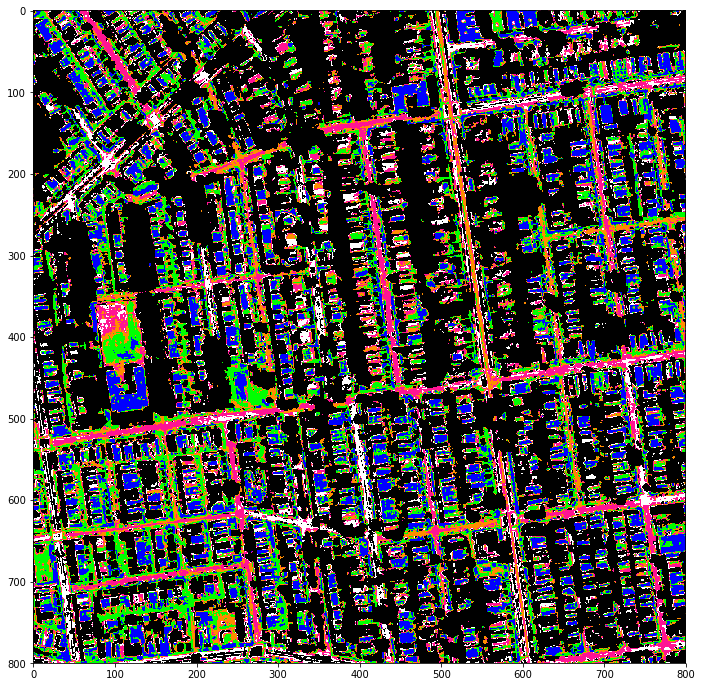

In [30]:
# Display mask
plt.imshow(image)